<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
SID = '^TWII'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(4847, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2000-01-04,8803.610352,8642.500000,8644.910156,8756.549805,0.0
2000-01-05,8867.679688,8668.019531,8690.599609,8849.870117,0.0
2000-01-06,9023.990234,8833.910156,8900.559570,8922.030273,0.0


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close,1.03,0.97,20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-14,10518.019531,10427.730469,10444.500000,10427.730469,2.618377e+09,1
2019-08-15,10374.750000,10287.759766,10374.750000,10327.129883,2.414020e+09,0
2019-08-16,10456.320312,10318.370117,10345.419922,10420.889648,2.566052e+09,0
2019-08-19,10516.049805,10449.389648,10449.389648,10488.750000,2.353813e+09,0
2019-08-20,10538.120117,10497.129883,10508.419922,10522.500000,2.290847e+09,0
2019-08-21,10545.250000,10504.490234,10526.870117,10525.799805,2.139265e+09,0
2019-08-22,10596.410156,10515.719727,10560.009766,10529.780273,2.281352e+09,0
2019-08-23,10541.730469,10503.070312,10526.150391,10538.110352,1.896147e+09,0
2019-08-26,10453.400391,10340.150391,10453.400391,10354.570312,2.015693e+09,0


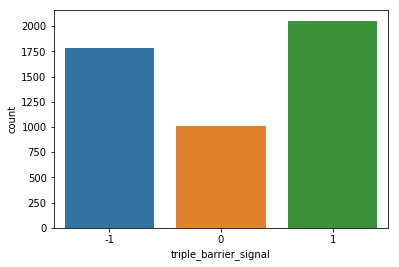

In [7]:
df['triple_barrier_signal'].value_counts()
sns.countplot(df['triple_barrier_signal'])

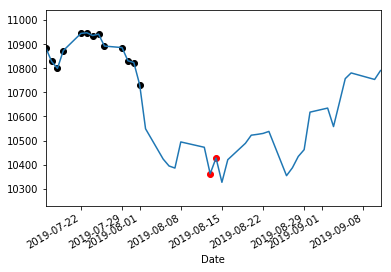

In [8]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][-40:].plot()#後20筆是前20筆的驗證
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][-40:].mean() - 2*df['Close'][-40:].std()
ub = df['Close'][-40:].mean() + 2*df['Close'][-40:].std()
plt.ylim(lb,ub)
plt.show()

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    4846.000000
mean       52.567720
std        17.312752
min         4.606342
25%        39.454287
50%        53.550274
75%        65.715994
max       100.000000
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662


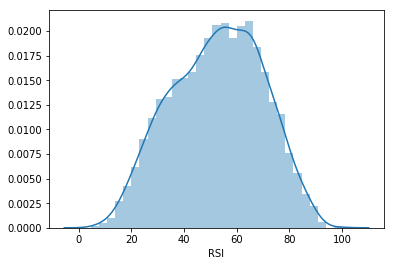

In [10]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    4834.000000
mean      -44.120851
std        32.199897
min      -100.000000
25%       -74.580554
50%       -39.430772
75%       -13.815743
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822


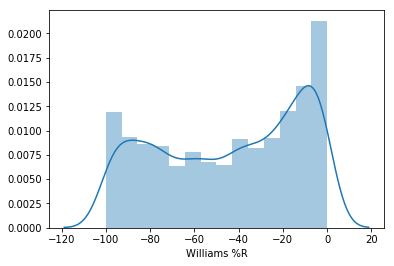

In [11]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count     4807.000000
mean      7619.314304
std       1788.294965
min       3821.469018
25%       6059.001572
50%       7800.676377
75%       8908.268793
max      10922.561952
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294


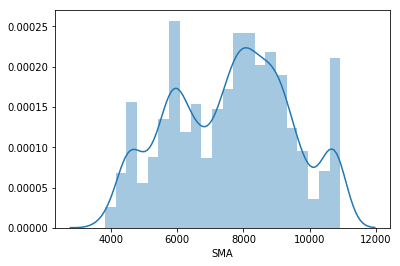

In [12]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count     4847.000000
mean      7637.221890
std       1804.157062
min       3570.937692
25%       6075.966996
50%       7809.771053
75%       8944.196694
max      11134.288080
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781


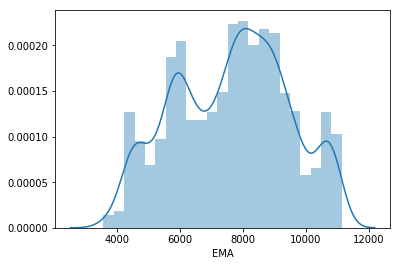

In [13]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count     4839.000000
mean      7634.613672
std       1806.685650
min       3546.690218
25%       6075.235758
50%       7794.572070
75%       8964.687229
max      11186.438932
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288


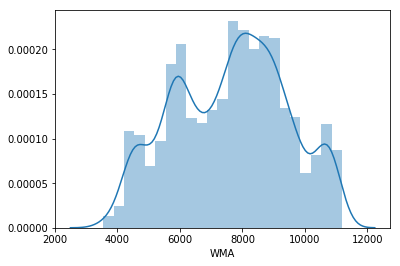

In [14]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count     4844.000000
mean      7637.152762
std       1809.457050
min       3488.004028
25%       6086.357800
50%       7795.695044
75%       8961.420532
max      11215.544141
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746


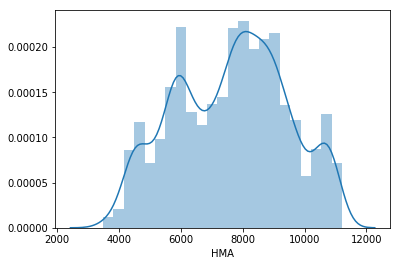

In [15]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count     4847.000000
mean      7638.664346
std       1812.349525
min       3447.605265
25%       6097.745443
50%       7792.508746
75%       8963.601760
max      11249.877643
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097


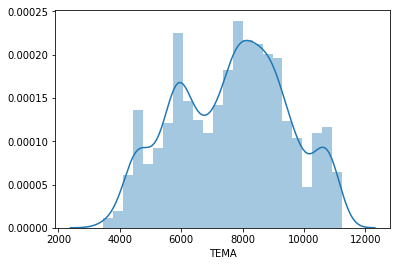

In [16]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    4846.000000
mean       10.076479
std        88.416970
min      -243.471940
25%       -64.510257
50%        23.323780
75%        83.791087
max       241.112021
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980


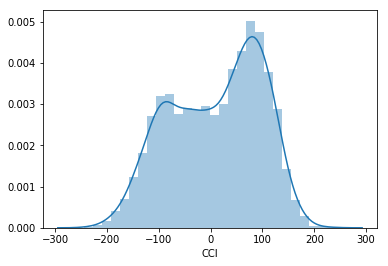

In [17]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    4838.000000
mean        5.921479
std        43.443525
min      -100.000000
25%       -26.266008
50%         7.426151
75%        39.153508
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856


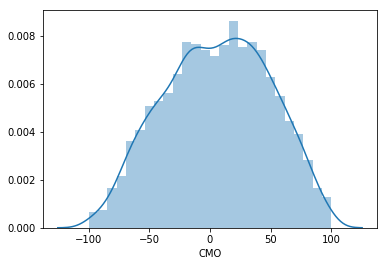

In [18]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    4847.000000
mean       -0.010605
std        31.298031
min      -129.904255
25%       -18.188879
50%         1.016593
75%        19.389864
max       124.384820
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751


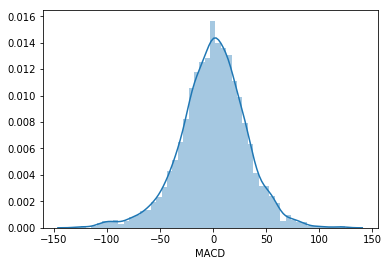

In [19]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    4847.000000
mean       -0.000112
std         0.453013
min        -1.925569
25%        -0.253029
50%         0.005990
75%         0.250432
max         1.956600
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735


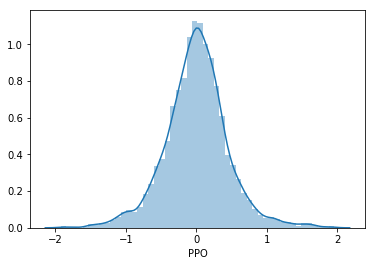

In [20]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    4835.000000
mean        0.152387
std         4.724344
min       -21.364491
25%        -2.305737
50%         0.503352
75%         2.806625
max        23.364389
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080,1.607051
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591


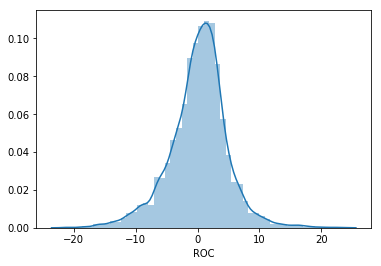

In [21]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    4.838000e+03
mean     1.353349e+11
std      5.649194e+11
min      0.000000e+00
25%      1.581163e+10
50%      3.427781e+10
75%      4.052608e+10
max      4.159094e+12
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080,1.607051,3.188413e+12
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12


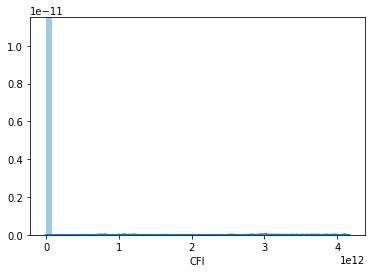

In [22]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    4764.000000
mean       -1.385472
std        24.007886
min      -145.864342
25%       -16.049083
50%         1.043823
75%        15.061799
max        85.851380
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080,1.607051,3.188413e+12,7.480887
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12,19.338268
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12,21.718306
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12,15.981934
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12,14.624074


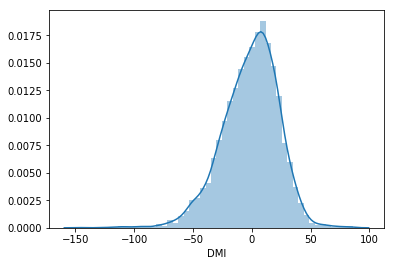

In [23]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count     4847.000000
mean      7622.646207
std       1817.880837
min       3411.679932
25%       6103.873665
50%       7790.099967
75%       8936.643366
max      11270.179688
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-04,10670.429688,10566.320312,10566.320312,10657.309570,2.090578e+09,0,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080,1.607051,3.188413e+12,7.480887,10405.660500
2019-09-05,10766.599609,10714.269531,10718.400391,10756.929688,2.805213e+09,0,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12,19.338268,10442.728186
2019-09-06,10803.070312,10753.450195,10783.459961,10780.639648,2.376172e+09,0,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12,21.718306,10494.547614
2019-09-10,10810.030273,10732.780273,10791.950195,10753.580078,2.275041e+09,0,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12,15.981934,10550.081700
2019-09-11,10815.589844,10746.870117,10787.650391,10790.349609,2.151830e+09,0,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12,14.624074,10602.071414


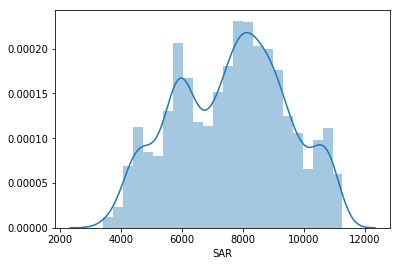

In [24]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [25]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(4847, 21)
(4764, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-04,63.617686,-3.726675,10642.344203,10551.153739,10476.856337,10615.047754,10639.891386,118.208425,19.683829,32.220685,0.305080,1.607051,3.188413e+12,7.480887,10405.660500,0
2019-09-05,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12,19.338268,10442.728186,0
2019-09-06,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12,21.718306,10494.547614,0
2019-09-10,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12,15.981934,10550.081700,0
2019-09-11,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12,14.624074,10602.071414,0


# 相關性分析

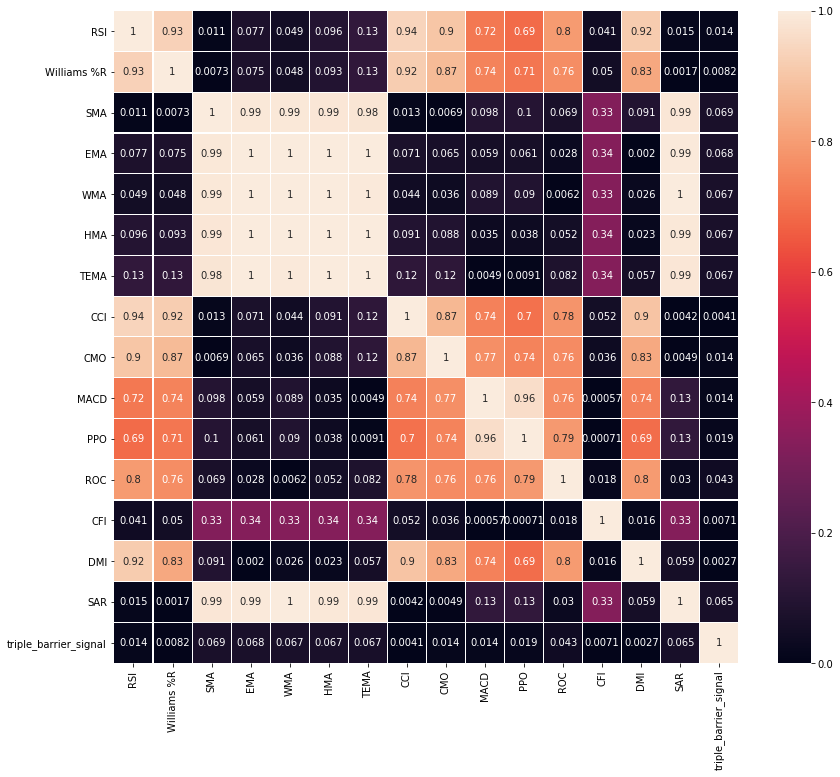

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-04,0.669172,0.962733,0.960539,0.922900,0.907120,0.922291,0.921819,0.746373,0.598419,0.691690,0.574588,0.513573,0.766612,0.661782,0.889989,0
2019-09-05,0.745295,0.977325,0.960725,0.928341,0.907180,0.924040,0.931498,0.837743,0.648015,0.727340,0.594980,0.527453,0.791416,0.712954,0.894706,0
2019-09-06,0.761521,0.951545,0.960663,0.933321,0.913285,0.926805,0.938713,0.808756,0.867714,0.748549,0.607020,0.531773,0.814172,0.723225,0.901300,0
2019-09-10,0.712927,0.879862,0.960355,0.936590,0.919601,0.936066,0.941066,0.751099,0.819260,0.745327,0.605078,0.525162,0.830100,0.698469,0.908367,0
2019-09-11,0.744501,0.946912,0.960238,0.940177,0.925720,0.941918,0.944279,0.736675,0.815959,0.743906,0.604122,0.531158,0.846590,0.692609,0.914983,0


In [28]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [29]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 4750/4750 [00:13<00:00, 341.51it/s]


準備完成


# check

In [30]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 4750
第一筆的index開始和結束:2000-05-10-2000-05-30
最後一筆的index開始和結束:2019-08-21-2019-09-11


# Reshape X

(圖片數量,長,寬,1張)

In [31]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(4750, 15, 15)
(4750, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [32]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(4750, 1)
[[ 1]
 [-1]
 [ 1]
 [-1]
 [-1]]


Using TensorFlow backend.


(4750, 3)
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

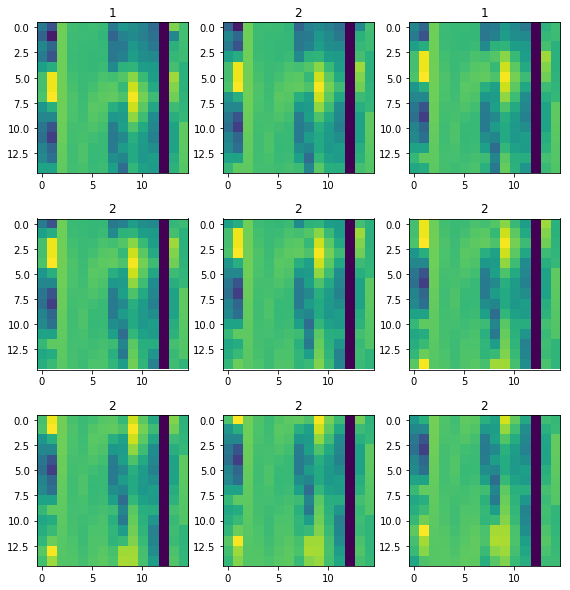

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and test sets

In [34]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(4710, 15, 15, 1) (4710, 3) (40, 15, 15, 1)


# 調整採樣

In [35]:
X_train2維 = X_train.reshape(X_train.shape[0],-1)
y_train數字 = np.array([ np.argmax(i) for i in y_train])
print(X_train2維.shape)
print(y_train數字.shape)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
X_train平衡 ,y_train平衡 = ros.fit_sample(X_train2維 ,y_train數字)
print(pd.DataFrame(y_train平衡)[0].value_counts().sort_index())#顯示結果

X_train = X_train平衡.reshape(X_train平衡.shape[0],15,15,1)#資料數,15,15,1
y_train = y_train平衡.reshape(y_train平衡.shape[0],1)#資料數,1
y_train = to_categorical(y_train , num_classes = 3)#one_hot
print(X_train.shape)
print(y_train.shape)

(4710, 225)
(4710,)
0    989
1    989
2    989
Name: 0, dtype: int64
(2967, 15, 15, 1)
(2967, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Split training and val sets

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size = 0.2,
                                              random_state = 42,
                                              shuffle = True,#是否洗牌
                                              stratify = y_train #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2373, 15, 15, 1) (2373, 3) (594, 15, 15, 1) (594, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [37]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

1    2005
2    1731
0    1014
dtype: int64

In [0]:
pd.Series([np.argmax(i) for i in y_train]).value_counts()

In [38]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

1    791
2    791
0    791
dtype: int64

In [39]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

2    198
1    198
0    198
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [41]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))#15,15,32
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))#15,15,64
model.add(MaxPool2D(pool_size=(5,5)))# 3,3,64
model.add(Flatten())#576
model.add(Dropout(0.5))#288
model.add(Dense(128, activation='relu'))#128
model.add(Dropout(0.5))#64
model.add(Dense(32, activation='relu'))#32
model.add(Dropout(0.5))#16
model.add(Dense(nclasses, activation='softmax'))#3
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               73856     


In [42]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=50,  
                   mode='max',
                   restore_best_weights=True)#恢復最佳權重

# fit

In [44]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 500,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2373 samples, validate on 594 samples
Epoch 1/500
2373/2373 [==============================] - 2s 867us/step - loss: 1.1025 - acc: 0.3325 - val_loss: 1.0942 - val_acc: 0.3401
Epoch 2/500
2373/2373 [==============================] - 0s 105us/step - loss: 1.0955 - acc: 0.3616 - val_loss: 1.0941 - val_acc: 0.4377
Epoch 3/500
2373/2373 [==============================] - 0s 109us/step - loss: 1.0942 - acc: 0.3510 - val_loss: 1.0852 - val_acc: 0.4108
Epoch 4/500
2373/2373 [==============================] - 0s 111us/step - loss: 1.0829 - acc: 0.4138 - val_loss: 1.0701 - val_acc: 0.4209
Epoch 5/500
2373/2373 [==============================] - 0s 113us/step - loss: 1.0680 - acc: 0.4176 - val_loss: 1.0583 - val_acc: 0.4394
Epoch 6/500
2373/2373 [==============================] - 0s 111us/step - loss: 1.0570 - acc: 0.4395 - val_loss: 1.0478 - val_acc: 0.4259
Epoch 7/500
2373/2373 [==============

# 訓練過程評估

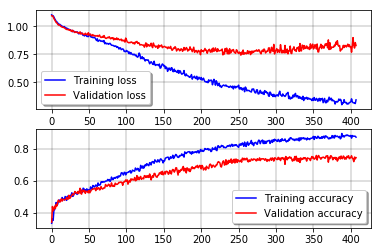

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

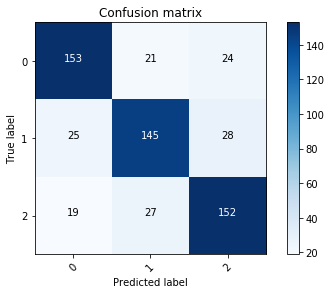

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [47]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


真實y值

In [48]:
print(yval[:5])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


# 分類報告

In [49]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.78      0.77      0.77       198
         BUY       0.75      0.73      0.74       198
        SELL       0.75      0.77      0.76       198

   micro avg       0.76      0.76      0.76       594
   macro avg       0.76      0.76      0.76       594
weighted avg       0.76      0.76      0.76       594
 samples avg       0.76      0.76      0.76       594



# plot error

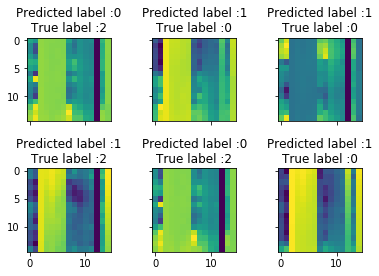

In [50]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [51]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

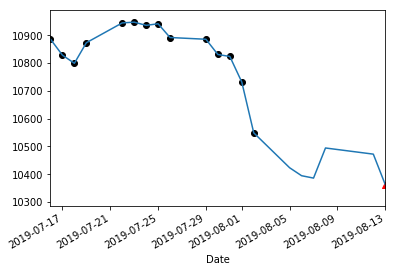

In [52]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 20~40筆

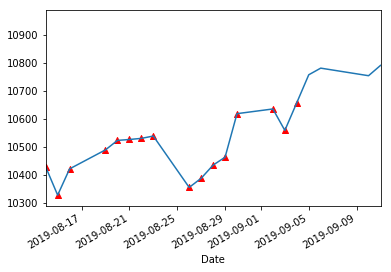

In [53]:
C['Close'][40:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 合併

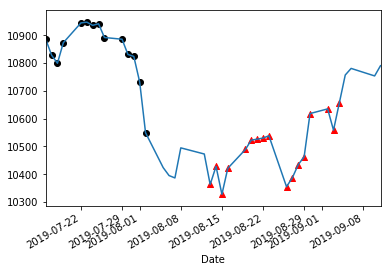

In [54]:
C['Close'][20:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 平滑版本

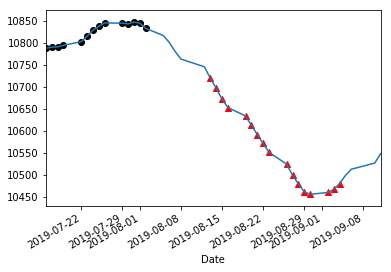

In [55]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

In [75]:
C = C.dropna(axis=0)
C

,Close,SIGNAL
Date,,
2019-07-16,10886.049805,2.0
2019-07-17,10828.480469,2.0
2019-07-18,10799.280273,2.0
2019-07-19,10873.190430,2.0
2019-07-22,10944.530273,2.0
2019-07-23,10947.259766,2.0
2019-07-24,10935.759766,2.0
2019-07-25,10941.410156,2.0
2019-07-26,10891.980469,2.0


In [80]:
np.set_printoptions(suppress=True)
C['HOLD%'] = model.predict(X_test)[:,0]
C['BUY%'] = model.predict(X_test)[:,1]
C['SELL%'] = model.predict(X_test)[:,2]
C.tail(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,Close,SIGNAL,HOLD%,BUY%,SELL%
Date,,,,,
2019-08-28,10434.290039,1.0,0.003169,0.996594,0.000236
2019-08-29,10462.429688,1.0,0.007737,0.991553,0.000709
2019-08-30,10618.049805,1.0,0.250865,0.733577,0.015557
2019-09-02,10634.849609,1.0,0.423921,0.541513,0.034566
2019-09-03,10558.209961,1.0,0.041368,0.950431,0.008200
2019-09-04,10657.309570,1.0,0.131676,0.859860,0.008464
2019-09-05,10756.929688,0.0,0.890916,0.061032,0.048053
2019-09-06,10780.639648,0.0,0.963897,0.011778,0.024326
2019-09-10,10753.580078,0.0,0.949469,0.015005,0.035526


# save model

In [0]:
model.save('Rikcy_net.h5')
del model

In [0]:
from keras.models import load_model
model = load_model('Rikcy_net.h5')
predict = model.predict(X_test)

In [85]:
predict[-5:]

array([[0.13167638, 0.8598599 , 0.00846379],
       [0.8909157 , 0.06103153, 0.0480527 ],
       [0.9638965 , 0.0117779 , 0.02432559],
       [0.9494689 , 0.01500464, 0.03552645],
       [0.9205573 , 0.01183178, 0.0676109 ]], dtype=float32)